# Neural Network Model(DenseNet)

In [1]:
from tensorflow.keras.layers import (Conv3D, BatchNormalization, AveragePooling3D, concatenate, Lambda,
                          Activation, Input, GlobalAvgPool3D, Dense)
from tensorflow.keras.regularizers import l2 as l2_penalty
from tensorflow.keras.models import Model

# from Model.metrics import invasion_acc, invasion_precision, invasion_recall, invasion_fmeasure

PARAMS = {
    'activation': lambda: Activation('relu'),  # the activation functions
    'bn_scale': True,  # whether to use the scale function in BN
    'weight_decay': 0.0001,  # l2 weight decay
    'kernel_initializer': 'he_uniform',  # initialization
    'first_scale': lambda x: x / 128. - 1.,  # the first pre-processing function
    'dhw': [32, 32, 32],  # the input shape
    'k': 8,  # the `growth rate` in DenseNet
    'bottleneck': 4,  # the `bottleneck` in DenseNet
    'compression': 2,  # the `compression` in DenseNet
    'first_layer': 32,  # the channel of the first layer
    'down_structure': [4, 4, 4],  # the down-sample structure
    'output_size': 2  # the output number of the classification head
}


def _conv_block(x, filters):
    bn_scale = PARAMS['bn_scale']
    activation = PARAMS['activation']
    kernel_initializer = PARAMS['kernel_initializer']
    weight_decay = PARAMS['weight_decay']
    bottleneck = PARAMS['bottleneck']

    x = BatchNormalization(scale=bn_scale, axis=-1)(x)
    x = activation()(x)
    x = Conv3D(filters * bottleneck, kernel_size=(1, 1, 1), padding='same', use_bias=False,
               kernel_initializer=kernel_initializer,
               kernel_regularizer=l2_penalty(weight_decay))(x)
    x = BatchNormalization(scale=bn_scale, axis=-1)(x)
    x = activation()(x)
    x = Conv3D(filters, kernel_size=(3, 3, 3), padding='same', use_bias=True,
               kernel_initializer=kernel_initializer,
               kernel_regularizer=l2_penalty(weight_decay))(x)
    return x


def _dense_block(x, n):
    k = PARAMS['k']

    for _ in range(n):
        conv = _conv_block(x, k)
        x = concatenate([conv, x], axis=-1)
    return x


def _transmit_block(x, is_last):
    bn_scale = PARAMS['bn_scale']
    activation = PARAMS['activation']
    kernel_initializer = PARAMS['kernel_initializer']
    weight_decay = PARAMS['weight_decay']
    compression = PARAMS['compression']

    x = BatchNormalization(scale=bn_scale, axis=-1)(x)
    x = activation()(x)
    if is_last:
        x = GlobalAvgPool3D()(x)
    else:
        *_, f = x.get_shape().as_list()
        x = Conv3D(f // compression, kernel_size=(1, 1, 1), padding='same', use_bias=True,
                   kernel_initializer=kernel_initializer,
                   kernel_regularizer=l2_penalty(weight_decay))(x)
        x = AveragePooling3D((2, 2, 2), padding='valid')(x)
    return x


def get_model(weights=None, **kwargs):
    for k, v in kwargs.items():
        assert k in PARAMS
        PARAMS[k] = v
    print("Model hyper-parameters:", PARAMS)

    dhw = PARAMS['dhw']
    first_scale = PARAMS['first_scale']
    first_layer = PARAMS['first_layer']
    kernel_initializer = PARAMS['kernel_initializer']
    weight_decay = PARAMS['weight_decay']
    down_structure = PARAMS['down_structure']
    output_size = PARAMS['output_size']

    shape = dhw + [1]

    inputs = Input(shape=shape)

    if first_scale is not None:
        scaled = Lambda(first_scale)(inputs)
    else:
        scaled = inputs
    conv = Conv3D(first_layer, kernel_size=(3, 3, 3), padding='same', use_bias=True,
                  kernel_initializer=kernel_initializer,
                  kernel_regularizer=l2_penalty(weight_decay))(scaled)

    downsample_times = len(down_structure)
    for l, n in enumerate(down_structure):
        db = _dense_block(conv, n)
        conv = _transmit_block(db, l == downsample_times - 1)

    if output_size == 1:
        last_activation = 'sigmoid'
    else:
        last_activation = 'softmax'

    outputs = Dense(output_size, activation=last_activation,
                    kernel_regularizer=l2_penalty(weight_decay),
                    kernel_initializer=kernel_initializer)(conv)

    model = Model(inputs, outputs)
    model.summary()

    if weights is not None:
        model.load_weights(weights, by_name=True)
    return model


def get_compiled(loss='categorical_crossentropy', optimizer='adam',
                 weights=None, **kwargs):
    metrics = ["categorical_accuracy"]
    model = get_model(weights=weights, **kwargs)
    model.compile(loss=loss, optimizer=optimizer,
                  metrics=[loss] + metrics)
    return model


if __name__ == '__main__':
    model = get_compiled()


Model hyper-parameters: {'activation': <function <lambda> at 0x7f61f1695f70>, 'bn_scale': True, 'weight_decay': 0.0001, 'kernel_initializer': 'he_uniform', 'first_scale': <function <lambda> at 0x7f61f169a430>, 'dhw': [32, 32, 32], 'k': 8, 'bottleneck': 4, 'compression': 2, 'first_layer': 32, 'down_structure': [4, 4, 4], 'output_size': 2}
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 32,  0           []                               
                                 1)]                                                              
                                                                                                  
 lambda (Lambda)                (None, 32, 32, 32,   0           ['input_1[0][0]']                
                                1)                 

# Data Pre-processing and Augmentation

In [2]:
import numpy as np
from tensorflow import keras
import csv
import random
from matplotlib import pyplot as plt


# data augment
def rotation(array, angle):
    X = np.rot90(array, angle[0], axes=(0, 1))  # rotate in X-axis
    Y = np.rot90(X, angle[1], axes=(0, 2))  # rotate in Y'-axis
    Z = np.rot90(Y, angle[2], axes=(1, 2))  # rotate in Z"-axis
    return Z


def reflection(array, axis):
    if axis != -1:
        ref = np.flip(array, axis)
    else:
        ref = np.copy(array)
    return ref


def augment(x_train, y_train):
    print(np.size(x_train, 0))
    for i in range(0, np.size(x_train, 0)):
        angle = (random.randint(0, 3), random.randint(0, 3), random.randint(0, 3))
        rotated_data = rotation(x_train[i], angle)
        axis = random.randint(-1, 2)
        flipped_data = reflection(x_train[i], axis)
        # for j in range(0, 32, 2):
        #     plt.figure()
        #     plt.subplot(1, 3, 1)
        #     plt.imshow(rotated_data[j])
        #     plt.subplot(1, 3, 2)
        #     plt.imshow(flipped_data[j])
        #     plt.subplot(1, 3, 3)
        #     plt.imshow(x_train[i][j])
        #     plt.show()
        x_train = np.append(x_train, np.expand_dims(rotated_data, axis=0), axis=0)
        x_train = np.append(x_train, np.expand_dims(flipped_data, axis=0), axis=0)
        y_train = np.append(y_train, np.expand_dims(y_train[i], axis=0), axis=0)
        y_train = np.append(y_train, np.expand_dims(y_train[i], axis=0), axis=0)
    return x_train, y_train


def load_label():
    path = 'drive/MyDrive/dataset2/train_val.csv'
    y_train = np.loadtxt(path, int, delimiter=",", skiprows=1, usecols=1)
    print('Labels loaded')
    return y_train

import pandas as pd

# load feature original=1->return the augmented data
def load_data(aug=False):
    focus = 16
    x_train = np.ones((365, 2 * focus, 2 * focus, 2 * focus))
    j = 0
    candidates = pd.read_csv('drive/MyDrive/dataset2/train_val.csv')['name']
    for c in candidates:
      a = 'drive/MyDrive/dataset2/train_val/' + c + '.npz'
      tmp = np.load(a)
      voxel = tmp['voxel']
      seg = tmp['seg']
      x_train[j] = (voxel * seg)[50 - focus:50 + focus, 50 - focus:50 + focus, 50 - focus:50 + focus]
      j = j + 1
    # for i in range(0, 480):
    #     a = 'drive/MyDrive/dataset2/train_val/candidate' + str(i) + '.npz'
    #     try:
    #         tmp = np.load(a)
    #         voxel = tmp['voxel']
    #         seg = tmp['seg']
    #         x_train[j] = (voxel * seg)[50 - focus:50 + focus, 50 - focus:50 + focus, 50 - focus:50 + focus]
    #         j = j + 1
    #     except:
    #         continue
    y_train = load_label()
    if aug is False:
        x_train = x_train.reshape(x_train.shape[0], 2 * focus, 2 * focus, 2 * focus, 1)
        y_train = keras.utils.to_categorical(y_train, 2)
        return x_train, y_train
    x_train, y_train = augment(x_train, y_train)
    x_train, y_train = mix_up(x_train, y_train)
    x_train = x_train.reshape(x_train.shape[0], 2 * focus, 2 * focus, 2 * focus, 1)
    y_train = keras.utils.to_categorical(y_train, 2)
    return x_train, y_train


def mix_up(x_train, y_train, increment=400):
    t = 0.5
    x = np.ones((increment, 32, 32, 32))
    y = np.ones(increment)
    i = 0
    size = np.size(x_train, 0)
    while i < increment:
        m = random.randint(0, size - 1)
        n = random.randint(0, size - 1)
        if y_train[m] == y_train[n]:
            x[i] = (t * x_train[m] + (1 - t) * x_train[n]).copy()
            y[i] = (t * y_train[m] + (1 - t) * y_train[n]).copy()
            i = i + 1
    # i = 0
    # for j in range(0, 32, 2):
    #     plt.figure()
    #     plt.subplot(1, 2, 1)
    #     plt.imshow(x[i][j])
    #     plt.subplot(1, 2, 2)
    #     plt.imshow(x_train[i][j])
    #     plt.show()
    final_x = np.append(x_train, x, axis=0)
    final_y = np.append(y_train, y)
    return final_x, final_y


# Self-Customized AUC Score Callback

In [3]:
# use sckit-learn to build the evaluation function
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback

AUC_Scores = []

class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()
        self.interval = interval
        self.x_val,self.y_val = validation_data
    def on_epoch_end(self, epoch, log={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.x_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print('\n ROC_AUC - epoch:%d - score:%.6f' % (epoch+1, score))
            AUC_Scores.append(score)
            


# Connect to Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Training Function

In [5]:
def train_model(x_train, y_train, x_val, y_val, epoch, batch_size, save_weight_path, load_weight_path):

  RocAuc = RocAucEvaluation(validation_data=(x_val, y_val), interval=1)

  tf.compat.v1.disable_eager_execution()

  # compile model
  model = get_compiled()
  # model_path = 'tmp/weights0618.09.h5'
  # model.load_weights(model_path)

  if load_weight_path != '':
    model.load_weights(load_weight_path)
    
    print("Weight Loaded! " + load_weight_path)
  # train
  checkpointer = ModelCheckpoint(filepath= save_weight_path + '.{epoch:02d}.h5', verbose=1,
                                  period=1, save_weights_only=True)
  history = model.fit(x_train,
            y_train,
            epochs=epoch,
            validation_data=(x_val, y_val),
            shuffle=True,
            batch_size=batch_size,
            callbacks=[RocAuc,checkpointer]
            )
  return history

# Train with Original Data

Labels loaded


Instructions for updating:
Colocations handled automatically by placer.


Labels loaded
(365, 32, 32, 32, 1) (365, 2)
(365, 32, 32, 32, 1) (365, 2)
Model hyper-parameters: {'activation': <function <lambda> at 0x7f61f1695f70>, 'bn_scale': True, 'weight_decay': 0.0001, 'kernel_initializer': 'he_uniform', 'first_scale': <function <lambda> at 0x7f61f169a430>, 'dhw': [32, 32, 32], 'k': 8, 'bottleneck': 4, 'compression': 2, 'first_layer': 32, 'down_structure': [4, 4, 4], 'output_size': 2}
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 32,  0           []                               
                                 1)]                                                              
                                                                                                  
 lambda_1 (Lambda)              (None, 32, 32, 32,   0           ['input_1

Train on 365 samples, validate on 365 samples
Epoch 1/30
365/365 [==============================] - ETA: 0s - loss: 0.8073 - categorical_crossentropy: 0.6925 - categorical_accuracy: 0.6247

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,



 ROC_AUC - epoch:1 - score:0.595117

Epoch 1: saving model to drive/MyDrive/tmp/dense_weights1210_8k_original_data.01.h5
365/365 [==============================] - 29s 79ms/sample - loss: 0.8073 - categorical_crossentropy: 0.6925 - categorical_accuracy: 0.6247 - val_loss: 0.8167 - val_categorical_crossentropy: 0.7023 - val_categorical_accuracy: 0.4603
Epoch 2/30
365/365 [==============================] - ETA: 0s - loss: 0.7457 - categorical_crossentropy: 0.6318 - categorical_accuracy: 0.6356
 ROC_AUC - epoch:2 - score:0.371072

Epoch 2: saving model to drive/MyDrive/tmp/dense_weights1210_8k_original_data.02.h5
365/365 [==============================] - 12s 34ms/sample - loss: 0.7457 - categorical_crossentropy: 0.6318 - categorical_accuracy: 0.6356 - val_loss: 0.8442 - val_categorical_crossentropy: 0.7307 - val_categorical_accuracy: 0.5644
Epoch 3/30
365/365 [==============================] - ETA: 0s - loss: 0.7495 - categorical_crossentropy: 0.6365 - categorical_accuracy: 0.6384
 ROC_

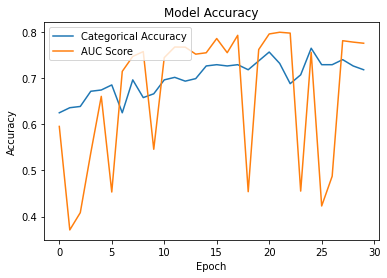

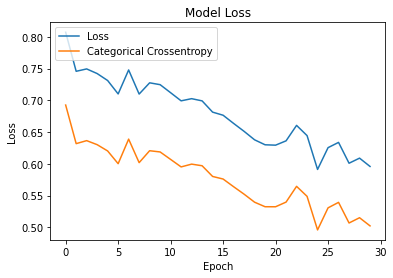

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt


import tensorflow as tf
import os

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

x_train, y_train = load_data()
x_val, y_val = load_data()
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

save_weight_path = 'drive/MyDrive/tmp/dense_weights1210_8k_original_data'
load_weight_path = ''
batch_size = 16
epoch = 30

AUC_Scores = []
ori_history = train_model(x_train, y_train, x_val, y_val, epoch, batch_size, save_weight_path, load_weight_path)

plt.plot(ori_history.history['categorical_accuracy'])
plt.plot(AUC_Scores)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Categorical Accuracy', 'AUC Score'], loc='upper left')
plt.show()

plt.plot(ori_history.history['loss'])
plt.plot(ori_history.history['categorical_crossentropy'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Categorical Crossentropy'], loc='upper left')
plt.show()





# Testing Function

In [7]:
from pandas.io.parsers.python_parser import parser_defaults
import os
import numpy as np
# from mylib.densenet import get_compiled
import tensorflow as tf
import os
import pandas as pd
import sklearn.metrics

def load_test():
    x_test = np.ones((100, 32, 32, 32))
    i = 0
    path = TEST_PATH  
    path_list = os.listdir(path)
    path_list.sort()  
    for filename in path_list:
        tmp = np.load(os.path.join(path, filename))
        voxel = tmp['voxel']
        seg = tmp['seg']
        x_test[i] = (voxel * seg)[50 - 16:50 + 16, 50 - 16:50 + 16, 50 - 16:50 + 16]
        i = i + 1
    x_test = x_test.reshape(x_test.shape[0], 32, 32, 32, 1)
    return x_test

def save_sub(input_list):
  candidates = list()
  for c in os.listdir(TEST_PATH):
    candidates.append(c.split(".")[0])
  candidates.sort()
  data = {"name": candidates, "label": input_list[:, 1]}
  df = pd.DataFrame(data)
  df.to_csv(SUBMISSION_CSV)
  print('File saved')

def test_model(TEST_CSV, TEST_PATH, SUBMISSION_CSV, TRAIN_MODEL_PATH):
  x_test = load_test()
  model = get_compiled()
  score_map = {} 
  labels_map = {}
  test_score = []

  best_score = 0
  second_best_score = 0
  best_weights = -1
  second_best_weights = -1

  true_labels = pd.read_csv(TEST_CSV)['label']

  for i in range(1, 30):
      if i < 10:
        model_path = TRAIN_MODEL_PATH + "0" + str(i) + '.h5'
      else:
        model_path = TRAIN_MODEL_PATH + str(i) + '.h5'
      model.load_weights(model_path)
      res = model.predict(x_test, batch_size, verbose=1)

      save_sub(res)
      file = pd.read_csv(SUBMISSION_CSV)
      
      predicted_labels = file['label']
      labels_map[i] = predicted_labels
      score = sklearn.metrics.roc_auc_score(true_labels, predicted_labels)
      test_score.append(score)
      score_map[i] = score
      if score > best_score:
        best_score = score
        best_weights = i
      elif score > second_best_score:
        second_best_score = score
        second_best_weights = i

  first_score = 0
  best_i = 0
  best_j = 0
  for i in range (1, 30):
    for j in range(i + 1, 30):
      best1 = [i * 0.5 for i in labels_map[i]]
      best2 = [i * 0.5 for i in labels_map[j]]
      predicted_labels = np.sum([best1, best2], axis = 0)
      score = sklearn.metrics.roc_auc_score(true_labels, predicted_labels)
      if score > first_score:
        first_score = score
        best_i = i
        best_j = j

  print(first_score)
  print(best_i)
  print(best_j)
  # best1 = [i * 0.5 for i in labels_map[best_weights]]
  # best2 = [i * 0.5 for i in labels_map[second_best_weights]]
  # predicted_labels = np.sum([best1, best2], axis = 0)
  # score = sklearn.metrics.roc_auc_score(true_labels, predicted_labels)
  # print(score)
  print(score_map)
  print("Test AUC Mean",np.mean(np.array(test_score)))
  print()
  print("Epoch: " + str(best_weights))
  print(labels_map[best_weights])
  print()
  print("Epoch: " + str(second_best_weights))
  print(labels_map[second_best_weights])

# Test the Unaugmented Data Model

In [8]:

batch_size = 16
TEST_CSV = 'drive/MyDrive/dataset2/test_val.csv'
TEST_PATH = "drive/MyDrive/dataset2/test"
SUBMISSION_CSV = "drive/MyDrive/dataset2/result.csv"
TRAIN_MODEL_PATH = "drive/MyDrive/tmp/dense_weights1210_8k_original_data."

test_model(TEST_CSV, TEST_PATH, SUBMISSION_CSV, TRAIN_MODEL_PATH)





Model hyper-parameters: {'activation': <function <lambda> at 0x7f61f1695f70>, 'bn_scale': True, 'weight_decay': 0.0001, 'kernel_initializer': 'he_uniform', 'first_scale': <function <lambda> at 0x7f61f169a430>, 'dhw': [32, 32, 32], 'k': 8, 'bottleneck': 4, 'compression': 2, 'first_layer': 32, 'down_structure': [4, 4, 4], 'output_size': 2}
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 32,  0           []                               
                                 1)]                                                              
                                                                                                  
 lambda_2 (Lambda)              (None, 32, 32, 32,   0           ['input_2[0][0]']                
                                1)               

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
0.6732
7
18
{1: 0.4424, 2: 0.3332, 3: 0.3564, 4: 0.44240000000000007, 5: 0.5012, 6: 0.3708, 7: 0.6696000000000001, 8: 0.6572, 9: 0.6596, 10: 0.4252, 11: 0.5880000000000001, 12: 0.5992, 13: 0.6564000000000001, 14: 0.6684, 15: 0.5868000000000001, 16: 0.6384, 17: 0.6648, 18: 0.6547999999999999, 19: 0.36000000000000004, 20: 0.5488, 21: 0.664, 22: 0.6, 23: 0.6144000000000001, 24: 0.36899999999999994, 25: 0.5232, 26: 0.3498, 27: 0.37420000000000003, 28: 0.6488, 29: 0.5932000000000001}
Test AUC Mean 0.5365586206896551

Epoch: 7
0     0.401587
1     0.464170
2     0.939790
3     0.641652
4     0.654042
        ...   
95    0.540378
96    0.939243
97    0.829031
98    0.981867
99  

# Get the Best Weight

In [9]:
import numpy
auc_original = numpy.array(AUC_Scores)
print(auc_original)
max_index = auc_original.argmax() + 1
max_val = np.max(auc_original)
min_val = np.min(auc_original)
mean_val = np.mean(auc_original)

print("Best Weight's Epoch is:", max_index)
print("Max Score is ", max_val)
print("Min Score is ", min_val)
print("Mean Score is ", mean_val)




[0.59511723 0.37107203 0.40841794 0.53779913 0.66020063 0.45312122
 0.71428571 0.74667634 0.75710056 0.54568528 0.74404762 0.76701112
 0.76673918 0.75157119 0.7545927  0.78541213 0.75474378 0.79236161
 0.45382372 0.76154218 0.79529248 0.79900894 0.79713561 0.45509276
 0.75546894 0.42292875 0.48730964 0.78066836 0.77764685 0.77522964]
Best Weight's Epoch is: 22
Max Score is  0.7990089436789944
Min Score is  0.3710720328740633
Mean Score is  0.6655701091773428


# Train with the Augmented data and the best Weight

Labels loaded
365
Labels loaded
(1495, 32, 32, 32, 1) (1495, 2)
(365, 32, 32, 32, 1) (365, 2)
Model hyper-parameters: {'activation': <function <lambda> at 0x7f61f1695f70>, 'bn_scale': True, 'weight_decay': 0.0001, 'kernel_initializer': 'he_uniform', 'first_scale': <function <lambda> at 0x7f61f169a430>, 'dhw': [32, 32, 32], 'k': 8, 'bottleneck': 4, 'compression': 2, 'first_layer': 32, 'down_structure': [4, 4, 4], 'output_size': 2}
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 32,  0           []                               
                                 1)]                                                              
                                                                                                  
 lambda_3 (Lambda)              (None, 32, 32, 32,   0

Weight Loaded! drive/MyDrive/tmp/dense_weights1210_8k_original_data.22.h5
Train on 1495 samples, validate on 365 samples
Epoch 1/30
1495/1495 [==============================] - ETA: 0s - loss: 0.7107 - categorical_crossentropy: 0.6153 - categorical_accuracy: 0.6696

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,



 ROC_AUC - epoch:1 - score:0.688150

Epoch 1: saving model to drive/MyDrive/tmp/dense_weights1210_8k_aug_data.01.h5
1495/1495 [==============================] - 51s 34ms/sample - loss: 0.7107 - categorical_crossentropy: 0.6153 - categorical_accuracy: 0.6696 - val_loss: 0.8026 - val_categorical_crossentropy: 0.7081 - val_categorical_accuracy: 0.5671
Epoch 2/30
1495/1495 [==============================] - ETA: 0s - loss: 0.7019 - categorical_crossentropy: 0.6084 - categorical_accuracy: 0.6756
 ROC_AUC - epoch:2 - score:0.779943

Epoch 2: saving model to drive/MyDrive/tmp/dense_weights1210_8k_aug_data.02.h5
1495/1495 [==============================] - 35s 23ms/sample - loss: 0.7019 - categorical_crossentropy: 0.6084 - categorical_accuracy: 0.6756 - val_loss: 0.7326 - val_categorical_crossentropy: 0.6404 - val_categorical_accuracy: 0.6712
Epoch 3/30
1495/1495 [==============================] - ETA: 0s - loss: 0.6783 - categorical_crossentropy: 0.5872 - categorical_accuracy: 0.7003
 ROC_AU

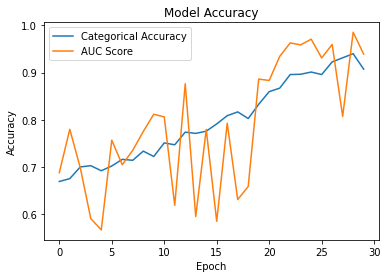

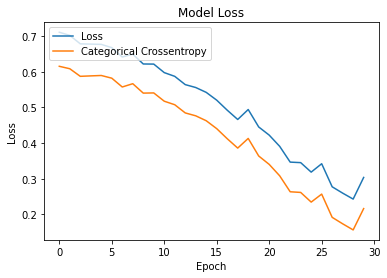

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt


import tensorflow as tf
import os

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

x_train, y_train = load_data(True)
x_val, y_val = load_data()
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

save_weight_path = 'drive/MyDrive/tmp/dense_weights1210_8k_aug_data'
if max_index < 10:
  load_weight_path = 'drive/MyDrive/tmp/dense_weights1210_8k_original_data.' + "0" + str(max_index) + '.h5'
else:
  load_weight_path = 'drive/MyDrive/tmp/dense_weights1210_8k_original_data.' + str(max_index) + '.h5'

batch_size = 16
epoch = 30

AUC_Scores = []
aug_history = train_model(x_train, y_train, x_val, y_val, epoch, batch_size, save_weight_path, load_weight_path)

plt.plot(aug_history.history['categorical_accuracy'])
plt.plot(AUC_Scores)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Categorical Accuracy', 'AUC Score'], loc='upper left')
plt.show()

plt.plot(aug_history.history['loss'])
plt.plot(aug_history.history['categorical_crossentropy'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Categorical Crossentropy'], loc='upper left')
plt.show()

# Test the Augmented Data Model

In [11]:

batch_size = 16
TEST_CSV = 'drive/MyDrive/dataset2/test_val.csv'
TEST_PATH = "drive/MyDrive/dataset2/test"
SUBMISSION_CSV = "drive/MyDrive/dataset2/result.csv"
TRAIN_MODEL_PATH = "drive/MyDrive/tmp/dense_weights1210_8k_aug_data."

test_model(TEST_CSV, TEST_PATH, SUBMISSION_CSV, TRAIN_MODEL_PATH)

Model hyper-parameters: {'activation': <function <lambda> at 0x7f61f1695f70>, 'bn_scale': True, 'weight_decay': 0.0001, 'kernel_initializer': 'he_uniform', 'first_scale': <function <lambda> at 0x7f61f169a430>, 'dhw': [32, 32, 32], 'k': 8, 'bottleneck': 4, 'compression': 2, 'first_layer': 32, 'down_structure': [4, 4, 4], 'output_size': 2}
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 32,  0           []                               
                                 1)]                                                              
                                                                                                  
 lambda_4 (Lambda)              (None, 32, 32, 32,   0           ['input_4[0][0]']                
                                1)               

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
File saved
0.68
20
21
{1: 0.46799999999999997, 2: 0.6652, 3: 0.5511999999999999, 4: 0.4152, 5: 0.4168, 6: 0.5612, 7: 0.4788, 8: 0.46480000000000005, 9: 0.5984, 10: 0.6135999999999999, 11: 0.6744, 12: 0.41879999999999995, 13: 0.6532, 14: 0.454, 15: 0.5884, 16: 0.36599999999999994, 17: 0.5172, 18: 0.46240000000000003, 19: 0.41559999999999997, 20: 0.6864000000000001, 21: 0.6275999999999999, 22: 0.6040000000000001, 23: 0.6255999999999999, 24: 0.6272, 25: 0.6252, 26: 0.5812, 27: 0.6024, 28: 0.6227999999999999, 29: 0.5731999999999999}
Test AUC Mean 0.5503034482758621

Epoch: 20
0     0.201544
1     0.258133
2     0.998291
3     0.938121
4     0.443711
        ...   
95    0.392927
96    0.

## More Statistics

In [12]:
import numpy
auc_aug = numpy.array(AUC_Scores)
print(auc_aug)
max_index = auc_aug.argmax() + 1
max_val = np.max(auc_aug)
min_val = np.min(auc_aug)
mean_val = np.mean(auc_aug)

print("Best Weight's Epoch is:", max_index)
print("Max Score is ", max_val)
print("Min Score is ", min_val)
print("Mean Score is ", mean_val)

[0.68814963 0.7799432  0.69857385 0.59124214 0.56716824 0.75691927
 0.70494924 0.73564781 0.77519942 0.81172951 0.80616993 0.61910805
 0.87620861 0.59551003 0.77964104 0.58539552 0.79284506 0.63134518
 0.65893159 0.88605874 0.88317319 0.93397994 0.96259367 0.95842398
 0.9704496  0.93083756 0.95923979 0.8072048  0.98513416 0.93895788]
Best Weight's Epoch is: 29
Max Score is  0.9851341551849166
Min Score is  0.567168237853517
Mean Score is  0.7890243533961809
